# Setting up the plot

In [7]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

corrections
https://louis.jachiet.com/tmp/qVgQt1LKnsv_TP2.html

# Spark ML

In this lab, we will identify malign/benign brest cancers

I downloaded the dataset at the url: http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data and putted it in hdfs for you.

# Load the data into a Dataframe

In [9]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.linalg import VectorUDT,Vectors

def toFloat(x):
    if x == '?':
        return 5.0
    else:
        return float(x)

def doLine(l):
    item=l.split(",")
    label = 1
    if item[10]=='2':
        label=0
    return (Vectors.dense([toFloat(e) for e in item[1:10]]),label)
    
raw_data = sc.textFile("hdfs:///datasets/breast-cancer-wisconsin.data")
schema = StructType([StructField("features", VectorUDT(), True),StructField("label",IntegerType(),True)])
data = SQLContext(sc).createDataFrame(raw_data.map(doLine),schema)
data.show(5,truncate=False)

+--------------------------------------+-----+
|features                              |label|
+--------------------------------------+-----+
|[5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0] |0    |
|[5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0]|0    |
|[3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0] |0    |
|[6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0] |0    |
|[4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0] |0    |
+--------------------------------------+-----+
only showing top 5 rows



In [4]:
# raw_data.collect()
raw_data.take(5)

['1000025,5,1,1,1,2,1,3,1,1,2',
 '1002945,5,4,4,5,7,10,3,2,1,2',
 '1015425,3,1,1,1,2,2,3,1,1,2',
 '1016277,6,8,8,1,3,4,3,7,1,2',
 '1017023,4,1,1,3,2,1,3,1,1,2']

In [5]:
data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



## What is the number of benigns and maligns tumor ?

In [25]:
# data.createOrReplaceTempView("data") #==> pour faire du sql 

In [6]:
data.groupBy('label').count().show()
# print("# of 0", data.filter(data['label']==0).count())
# print("# of 1",data.filter(data['label']==1).count())

+-----+-----+
|label|count|
+-----+-----+
|    1|  241|
|    0|  458|
+-----+-----+



In [27]:
from pyspark.sql.functions import col, countDistinct
data.select(countDistinct(col('label'))).show()

+---------------------+
|count(DISTINCT label)|
+---------------------+
|                    2|
+---------------------+



## 2 Splitting into training and testing

In [7]:
train,test = data.randomSplit([0.9,0.1],seed=42)

In [8]:
print("train", train.count())
print("test", test.count())

train 624
test 75


## 3 Train a first model

In [10]:
# Train a DecisionTree model.
clf = DecisionTreeClassifier(labelCol="label", featuresCol="features")
bc_model = clf.fit(train)

## 4 - Evaluate the model

<div class="alert alert-block alert-danger">
DO: What does the DataFrame prediction contain ?<br/>
DO: What is the area under ROC of our classifier ?<br/>
DO: What is the accuracy of our classifier ?<br/>
    </div>

<div class="alert alert-block alert-info">

DO: What does the DataFrame prediction contain ?
<p>
Raw prediction for each possible label: gives a measure of confidence in each possible label (where larger = more confident).
    368 for 0 and 1 for 1 ==> measure of confidence in the label 0 is higher than the one for 1
</p>
<p>
probability:
    probability to predict each class
</p>
<p>
area Under ROC:
    AreaUnderROC = probabilité de correctement distinguer 2 échantillons, 1 négatif et 1 positif
</p>
</div>

In [16]:
predictions = bc_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label",metricName='areaUnderROC')
result = evaluator.evaluate(predictions)
print("areaUnderROC",result)
print("accuracy",predictions.filter("label=prediction").count()/predictions.count())

areaUnderROC 0.9322742474916389
accuracy 0.9333333333333333


In [15]:
predictions = bc_model.transform(test)
predictions.show(5,truncate=False)

+-------------------------------------+-----+-------------+-----------------------------------------+----------+
|features                             |label|rawPrediction|probability                              |prediction|
+-------------------------------------+-----+-------------+-----------------------------------------+----------+
|[1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0]|0    |[368.0,1.0]  |[0.997289972899729,0.0027100271002710027]|0.0       |
|[1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0]|0    |[368.0,1.0]  |[0.997289972899729,0.0027100271002710027]|0.0       |
|[1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0]|0    |[368.0,1.0]  |[0.997289972899729,0.0027100271002710027]|0.0       |
|[1.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0]|0    |[368.0,1.0]  |[0.997289972899729,0.0027100271002710027]|0.0       |
|[1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0]|0    |[368.0,1.0]  |[0.997289972899729,0.0027100271002710027]|0.0       |
+-------------------------------------+-----+-------------+-------------------------------------

## Show trained model

In [20]:
# print(bc_model.toDebugString)
print(bc_model._java_obj.getMaxDepth())
print(bc_model._java_obj.getMaxBins())

5
32


## Optional: Plot the ROC curve

<div class="alert alert-block alert-danger"> Remarque: J'ai modifié la fonction plot pour pouvoir afficher la légende dans les graphes </div>

In [22]:
def get_curve(predictions):
    points = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).collect()
    # points should be array containing on the first column 
    # the probability of being a 1 and in the second column
    # the label.
    points.sort()# sorts the points on the probability
    
    # First we compute the total number of True and False
    nbFalse = 0.
    nbTrue = 0.
    for i in points:
        nbFalse += i[1]
        nbTrue += 1-i[1]
    
    # We now use a sliding window algorithm to compute the ROC points
    # At the beggining we have seen 0 False, 0 True
    false_positive = 0
    true_positive = 0
    fpr=[0]
    tpr=[0]
    last_proba = -1 # we want one point for each possible threshold
    for (proba,label) in points:
        false_positive += label
        true_positive += 1-label
        if last_proba == proba: # remove last point if it was not taking into
            del tpr[-1]         # account all the points at a given threshold
            del fpr[-1]
        last_proba = proba
        fpr.append(false_positive/nbFalse)
        tpr.append(true_positive/nbTrue)
    
    fpr.append(1)
    tpr.append(1)
    return (fpr,tpr)
        
def get_area(xs,ys):
    # supposes that the curve starts in (0,0) and finishes in (1,1)
    area = 0
    last_x = 0
    last_y = 0
    for i in range(len(xs)):
        area += (xs[i]-last_x)*(ys[i]+last_y)/2.
        last_x = xs[i]
        last_y = ys[i]
    return area

def plot(*spredictions):
    plt.title("ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
#     print("spredictions",spredictions)
#     for predictions in spredictions:
    for predictions in spredictions:
        FPR,TPR = get_curve(predictions[1])
        area = get_area(FPR,TPR)
        print("Area Under ROC "+str(area))
        plt.plot(FPR,TPR,label=predictions[0])
        plt.legend()

Area Under ROC 0.9331103678929766


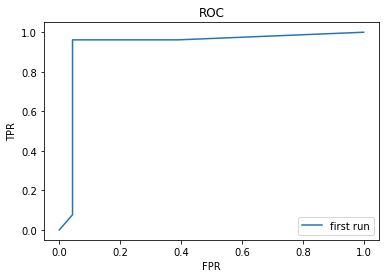

In [23]:
plot(("first run",predictions))

## Grid builder

In [24]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

##### DO: Use train-validation to determine a good set of parameters.

In [25]:
%%time
clf=DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder()\
        .addGrid(clf.impurity, ["entropy", "gini"])\
        .addGrid(clf.maxDepth,[1,3,5,7])\
        .addGrid(clf.maxBins,[2,5,10,20,32])\
        .build()
evaluator = BinaryClassificationEvaluator(labelCol="label",metricName='areaUnderROC')
tvs = TrainValidationSplit(estimator=clf,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.9)
# Run TrainValidationSplit, and choose the best set of parameters.
modelBest1 = tvs.fit(train)

CPU times: user 1.7 s, sys: 664 ms, total: 2.36 s
Wall time: 25.8 s


In [35]:
predictionsBest1=modelBest1.transform(test)#.select("features", "label", "prediction")
print(predictionsBest1.select("features", "label", "prediction").show(5))
resultBest1=evaluator.evaluate(predictionsBest1)
print("auroc",resultBest1)
print("accuracy",predictionsBest1.filter("label=prediction").count()/predictionsBest1.count())

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[1.0,1.0,1.0,1.0,...|    0|       0.0|
|[1.0,1.0,1.0,1.0,...|    0|       0.0|
|[1.0,1.0,1.0,1.0,...|    0|       0.0|
|[1.0,1.0,1.0,1.0,...|    0|       0.0|
|[1.0,1.0,1.0,1.0,...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

None
auroc 0.967391304347826
accuracy 0.96


In [29]:
bestModel1=modelBest1.bestModel
print("maxDepth",bestModel1._java_obj.getMaxDepth())
print("maxBins",bestModel1._java_obj.getMaxBins())
print("impurity",bestModel1._java_obj.getImpurity())
# print(bestModel.toDebugString)

maxDepth 5
maxBins 2
impurity entropy


## Cross-validation

##### DO: Use cross-validation to determine a good set of parameters.

In [30]:
%%time
clf=DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder()\
        .addGrid(clf.impurity, ["entropy", "gini"])\
        .addGrid(clf.maxDepth,[1,3,5,7])\
        .addGrid(clf.maxBins,[2,5,10,20,32])\
        .build()

evaluator = BinaryClassificationEvaluator(labelCol="label",metricName='areaUnderROC')

crossval = CrossValidator(estimator=clf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
modelBest2 = crossval.fit(train)

CPU times: user 8.27 s, sys: 3.44 s, total: 11.7 s
Wall time: 1min 34s


In [36]:
%%time
predictionsBest2=modelBest2.transform(test)#.select("features", "label", "prediction")
resultBest2=evaluator.evaluate(predictionsBest2)
print("auroc",resultBest2)
print("accuracy",predictionsBest2.filter("label=prediction").count()/predictionsBest2.count())

auroc 0.9753344481605352
accuracy 0.96
CPU times: user 18.7 ms, sys: 5.16 ms, total: 23.8 ms
Wall time: 511 ms


In [33]:
bestModel2=modelBest2.bestModel
print("maxDepth",bestModel2._java_obj.getMaxDepth())
print("maxBins",bestModel2._java_obj.getMaxBins())
print("impurity",bestModel2._java_obj.getImpurity())
# print(bestModel.toDebugString)

maxDepth 3
maxBins 5
impurity entropy


## Show best model features

In [39]:
clfBest=DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3, maxBins=5,impurity="entropy")
bestModelF = clfBest.fit(train)
predictionsBestF = bestModelF.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label",metricName='areaUnderROC')
resultF = evaluator.evaluate(predictionsBestF)
print("auroc Best Model", resultF)
print("accuracy",predictionsBestF.filter("label=prediction").count()/predictionsBestF.count())

auroc Best Model 0.975334448160535
accuracy 0.96


## Plot the various ROC of our various models

##### DO: What is the area under ROC of your model now ?

Area Under ROC 0.9753344481605352
Area Under ROC 0.9623745819397993
Area Under ROC 0.9753344481605352


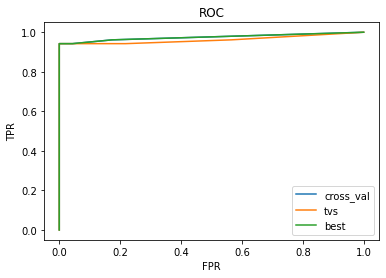

In [40]:
# plot(cvs_predictions,tvs_predictions,predictions)
# tvs_predictions=predictionsBest1
# cvs_predictions=predictionsBest2
# predictions=predictionsBestF
plot(("cross_val",predictionsBest2),("tvs",predictionsBest1),("best",predictionsBestF))

# Second task

# 6.1 Improve the classification

##### Consider different models for the Breast Cancer task (e.g. Logistic Regression, Random Forest model and Gradient-boosted tree classifier).

In [41]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

In [43]:
def runModels(models_list,train,test,evaluator):
    predictions_set=[]
    auroc=[]
    accuracy_res=[]

    for model_name, model in models_list:
#         print(model_name)
        clf = model.fit(train)
        predictions = clf.transform(test)

        result_acc=predictions.filter("label=prediction").count()/predictions.count()
        accuracy_res.append((model_name,result_acc))

        predictions_set.append((model_name,predictions))

        result_auc = evaluator.evaluate(predictions)
        auroc.append((model_name,result_auc))

        print("accuracy ",model_name," ", result_acc)
        
    return predictions_set,accuracy_res,auroc

In [45]:
lr = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10, regParam=0.3, elasticNetParam=0.8)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

models=[('LR',lr),('RF',rf),('GBT',gbt)]
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label",metricName='areaUnderROC')
predictions_set,accuracy_res,auroc=runModels(models,train,test,evaluator)

accuracy  LR   0.9066666666666666
accuracy  RF   0.96
accuracy  GBT   0.9466666666666667


In [46]:
accuracy_res

[('LR', 0.9066666666666666), ('RF', 0.96), ('GBT', 0.9466666666666667)]

In [47]:
auroc

[('LR', 0.9974916387959867),
 ('RF', 0.9832775919732442),
 ('GBT', 0.9665551839464883)]

Area Under ROC 0.9974916387959866
Area Under ROC 0.9832775919732442
Area Under ROC 0.9665551839464883


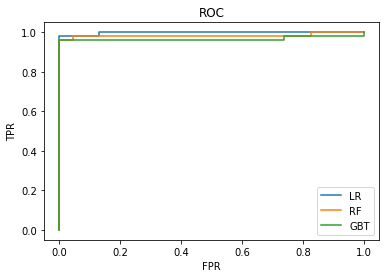

In [49]:
plot(predictions_set[0],predictions_set[1],predictions_set[2])

# 6.2 Another classification task (IRIS dataset)

Use the knowledge developed in this lab to classify plants. 
The dataset is available on the hdfs at hdfs:///datasets/iris.data
https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data 
and presented here https://archive.ics.uci.edu/ml/datasets/Iris 
You should make a classifier, classifying the species.

In [134]:
from pyspark.sql.types import StringType
# raw_data = sc.textFile("hdfs:///datasets/iris.data")

def doLine(l):
    item=l.split(",")
    if len(item)==5:
        if item[4]=='Iris-versicolor':
            label=1
        elif item[4]=='Iris-virginica':
            label=2
        else:
            label = 0
        res=(Vectors.dense([toFloat(e) for e in item[0:4]]),label)
    else:
        res=1
    return res

#setosa =0, versicolor=1, virginica=2

raw_data = sc.textFile("hdfs:///datasets/iris.data")
schema = StructType([StructField("features", VectorUDT(), True),StructField("label",IntegerType(),True)])
dataIris = SQLContext(sc).createDataFrame(raw_data.map(doLine).filter(lambda l: l!=1),schema)
dataIris.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[5.1,3.5,1.4,0.2]|    0|
|[4.9,3.0,1.4,0.2]|    0|
|[4.7,3.2,1.3,0.2]|    0|
|[4.6,3.1,1.5,0.2]|    0|
|[5.0,3.6,1.4,0.2]|    0|
+-----------------+-----+
only showing top 5 rows



In [52]:
dataIris.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   50|
|    2|   50|
|    0|   50|
+-----+-----+



In [53]:
trainIris, testIris=dataIris.randomSplit([0.8,0.2],seed=42)
print("# train", trainIris.count())
print("# train", testIris.count())

# train 115
# train 35


##### Normalization & Model training

In [55]:
from pyspark.ml.feature import StandardScaler

In [56]:
# StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=True, withMean=True)
scalerModel = scaler.fit(trainIris)
train_sc = scalerModel.transform(trainIris)
test_sc  = scalerModel.transform(testIris)

# lr = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10, regParam=0.3, elasticNetParam=0.8)
# rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

lr = LogisticRegression(labelCol="label", featuresCol="scaledFeatures",maxIter=10, regParam=0.3, elasticNetParam=0.8)
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures", numTrees=10)

models=[('LR',lr),('RF',rf)]

evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName="accuracy")
predictions_set,accuracy_res,auroc=runModels(models,train_sc,test_sc,evaluator)

accuracy  LR   0.4
accuracy  RF   0.9714285714285714


In [57]:
auroc

[('LR', 0.4), ('RF', 0.9714285714285714)]

In [58]:
accuracy_res

[('LR', 0.4), ('RF', 0.9714285714285714)]

Area Under ROC 0.07624113475177306
Area Under ROC 0.4769503546099291


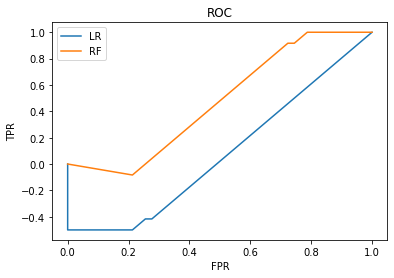

In [59]:
plot(predictions_set[0],predictions_set[1])

# 6.3 Visualization task (IRIS dataset)

##### Use the PCA algorithm and matplotlib to help you visualize the Iris dataset (see section above). Can you guess the groups ?

In [60]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

### In this section, I use the whole data ==> dataIris

#### Without normalization

+-------------------+-------------------+-----+
|                PC1|                PC2|label|
+-------------------+-------------------+-----+
| -2.827135972679017|-5.6413310455733585|    0|
|-2.7959524821488357| -5.145166883252947|    0|
|-2.6215235581650496| -5.177378121203942|    0|
+-------------------+-------------------+-----+
only showing top 3 rows



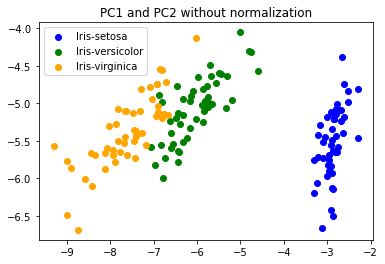

In [133]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(dataIris)

dataIris_pca = model.transform(dataIris).select("pcaFeatures","label")
# train_pca.show(truncate=False)

dataIris_pca=dataIris_pca.rdd.map(lambda x: [float(x[0][0]),float(x[0][1]),x[1]])#convert to three columns
dataIrisPca = SQLContext(sc).createDataFrame(dataIris_pca)
dataIrisPca=dataIrisPca.toDF('PC1','PC2','label')
dataIrisPca.show(3)

colors = ['blue', 'green', 'orange']
lw = 2
label_names=['Iris-setosa','Iris-versicolor','Iris-virginica']

for color, i, target_name in zip(colors, [0, 1, 2], label_names):
    list_pc1=dataIrisPca.filter(dataIrisPca['label']== i).select("PC1").rdd.map(lambda x: x[0]).collect()
    list_pc2=dataIrisPca.filter(dataIrisPca['label']== i).select("PC2").rdd.map(lambda x: x[0]).collect()
    
    plt.title("PC1 and PC2 without normalization")
    plt.scatter(list_pc1,list_pc2,color=color,label=target_name)
    plt.legend()

#### With normalization

+------------------+-------------------+-----+
|               PC1|                PC2|label|
+------------------+-------------------+-----+
|2.2569806330680255|-0.5040154042276549|    0|
|2.0794591188954015| 0.6532163936125878|    0|
|2.3600440815842068| 0.3174139445702809|    0|
+------------------+-------------------+-----+
only showing top 3 rows



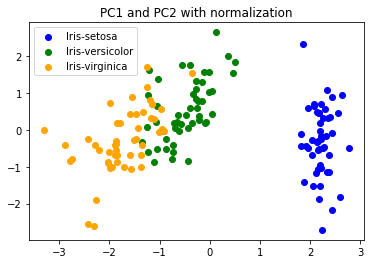

In [132]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=True, withMean=True)
scalerModel = scaler.fit(dataIris)
dataIris_sc = scalerModel.transform(dataIris)

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(dataIris_sc)

dataIris_pca = model.transform(dataIris_sc).select("pcaFeatures","label")
# train_pca.show(truncate=False)

dataIris_pca=dataIris_pca.rdd.map(lambda x: [float(x[0][0]),float(x[0][1]),x[1]])#.collect()
dataIrisPca = SQLContext(sc).createDataFrame(dataIris_pca)
dataIrisPca=dataIrisPca.toDF('PC1','PC2','label')
dataIrisPca.show(3)

colors = ['blue', 'green', 'orange']
lw = 2
label_names=['Iris-setosa','Iris-versicolor','Iris-virginica']

for color, i, target_name in zip(colors, [0, 1, 2], label_names):
    list_pc1=dataIrisPca.filter(dataIrisPca['label']== i).select("PC1").rdd.map(lambda x: x[0]).collect()
    list_pc2=dataIrisPca.filter(dataIrisPca['label']== i).select("PC2").rdd.map(lambda x: x[0]).collect()
    
    plt.title("PC1 and PC2 with normalization")
    plt.scatter(list_pc1,list_pc2,color=color,label=target_name)
    plt.legend()

# 6.4 Clustering task (IRIS dataset)

<div>
Remove the “class” information from the IRIS dataset and try to cluster then compare the result 
of your clustering with the label information.
    </div>

<h4>Remarque</h4>
<div>Je n'ai pas fait de split train and test, j'ai travaillé sur le dataset total, 
je pense que le but est de voir comment on applique le clustering
</div>

### Preparing the data

In [70]:
dataIrisCluster=dataIris.select('features')
dataIrisCluster.show(5)

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+-----------------+
only showing top 5 rows



### KMeans

In [69]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [71]:
# Trains a k-means model.
kmeans = KMeans().setK(3).setSeed(1)
modelKM = kmeans.fit(dataIrisCluster)

# Make predictions
predictionsKM = modelKM.transform(dataIrisCluster)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictionsKM)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Evaluate clustering.
# computeCost is deprecated and will be removed in 3.0.0
# cost = model.computeCost(dataIrisCluster)
# print("Within Set Sum of Squared Errors = " + str(cost))

print("training cost",modelKM.summary.trainingCost)

# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = modelKM.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Silhouette with squared euclidean distance = 0.7342113066202743
training cost 78.94506582597703
Cluster Centers: 
[5.88360656 2.74098361 4.38852459 1.43442623]
[5.006 3.418 1.464 0.244]
[6.85384615 3.07692308 5.71538462 2.05384615]


In [72]:
print("cluster size", modelKM.summary.clusterSizes)
predictionsKM.groupBy('prediction').count().show()

cluster size [61, 50, 39]
+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   39|
|         0|   61|
+----------+-----+



### Gaussian Mixture Model

In [74]:
from pyspark.ml.clustering import GaussianMixture

In [75]:
gmm = GaussianMixture().setK(3).setSeed(538009335)
modelGMM = gmm.fit(dataIrisCluster)
predictionsGMM = modelGMM.transform(dataIrisCluster)

print("cluster size", modelGMM.summary.clusterSizes)
predictionsGMM.groupBy('prediction').count().show()
# same than modelGMM.summary.clusterSizes ==> [0,1,2]

cluster size [50, 25, 75]
+----------+-----+
|prediction|count|
+----------+-----+
|         1|   25|
|         2|   75|
|         0|   50|
+----------+-----+



In [76]:
print("logLikelihood", modelGMM.summary.logLikelihood)
print("GMM weights", modelGMM.weights)
modelGMM.summary.probability.show(3,truncate=False)

logLikelihood -195.79947157497702
GMM weights [0.3333331115229638, 0.15835818952599504, 0.5083086989510411]
+------------------------------------------------------------------+
|probability                                                       |
+------------------------------------------------------------------+
|[0.9999999999999951,4.682229962936943E-17,4.868372929925642E-15]  |
|[0.9999999997048344,1.0042621613054077E-16,2.9516544389843495E-10]|
|[0.9999999999973134,7.291766565131807E-17,2.6865319365371256E-12] |
+------------------------------------------------------------------+
only showing top 3 rows



In [66]:
# modelGMM.gaussiansDF.show(truncate=False)

### Compare clustering to real labels

In [77]:
dataGby=dataIris.groupBy('label').count().withColumnRenamed("count","count_initial")
predKmGby=predictionsKM.groupBy('prediction').count().withColumnRenamed("count","count_predKM")
predGmmGby=predictionsGMM.groupBy('prediction').count().withColumnRenamed("count","count_predGMM")

In [78]:
first_join=dataGby.join(predKmGby,dataGby['label']==predKmGby['prediction'])
df_res=first_join.join(predGmmGby,first_join['label']==predGmmGby['prediction'])
df_res=df_res.orderBy('label')
df_res.show()
# movies.join(ratings, movies["movieId"]==ratings["movieId"])

+-----+-------------+----------+------------+----------+-------------+
|label|count_initial|prediction|count_predKM|prediction|count_predGMM|
+-----+-------------+----------+------------+----------+-------------+
|    0|           50|         0|          61|         0|           50|
|    1|           50|         1|          50|         1|           25|
|    2|           50|         2|          39|         2|           75|
+-----+-------------+----------+------------+----------+-------------+



For label 1 ==> same results 
For label 2 and 3 ==> 11 labels not correctly labelised

In [79]:
x_axis=df_res.select('label').rdd.map(lambda x: x[0]).collect()
y_raw=df_res.select('count_initial').rdd.map(lambda x: x[0]).collect()
y_KM=df_res.select('count_predKM').rdd.map(lambda x: x[0]).collect()
y_GMM=df_res.select('count_predGMM').rdd.map(lambda x: x[0]).collect()

In [92]:
# import matplotlib.pyplot as plt

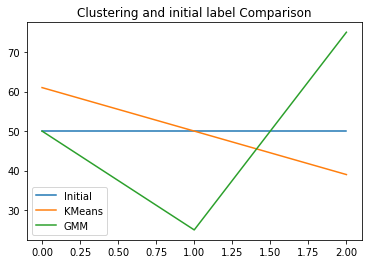

In [80]:
plt.title('Clustering and initial label Comparison')
# plt.scatter(x_axis,y_raw,label="Initial")
# plt.scatter(x_axis,y_KM,label="KMeans")
# plt.scatter(x_axis,y_GMM,label="GMM")

plt.plot(x_axis,y_raw,label="Initial")
plt.plot(x_axis,y_KM,label="KMeans")
plt.plot(x_axis,y_GMM,label="GMM")
plt.plot(loc='lower left')

plt.legend(loc='lower left')

Conclusion: KMeans seems to predict more accurate labels than the GMM

## 6.5 Regression task (WINE QUALITY dataset)

Estimate Wine Quality based on chemical components. 
See https://archive.ics.uci.edu/ml/datasets/Wine+Quality for the dataset. 
The two datasets can be found here : https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ 
and they are available on the hdfs at
hdfs:///datasets/winequality-red.data 
and 
hdfs:///datasets/winequality-white.data
        
(what happens if you train a regression on the white wine dataset and use it for the red wine dataset ?).

<div class="alert alert-block alert-danger"> 
Remarque: J'ai essayé de télécharger les données en utilisant le lien hdfs mais j'ai eu un message d'erreur:
    Input path does not exist: hdfs:/datasets/winequality-red.data.
<p>J'ai donc opté pour faire du web scaping pour récupérer les données. J'espère que c'est correct ==> il faut aller plus bas après le message d'erreur pour voir la suite </p>
    </div>

In [32]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.linalg import VectorUDT,Vectors

def doLine(l):
    item=l.split(";")
    return (Vectors.dense([float(e) for e in item[:11]]),int(item[-1]))
    
raw_data_red = sc.textFile("hdfs:///datasets/winequality-red.data")
schema = StructType([StructField("features", VectorUDT(), True),StructField("label",IntegerType(),True)])
dataWine = SQLContext(sc).createDataFrame(sc.parallelize(raw_data_red.collect()[1:]).map(doLine),schema)
dataWine.show(5)

# ==> Message d'erreur : Input path does not exist: hdfs:/datasets/winequality-red.data

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[7.4,0.7,0.0,1.9,...|    5|
|[7.8,0.88,0.0,2.6...|    5|
|[7.8,0.76,0.04,2....|    5|
|[11.2,0.28,0.56,1...|    6|
|[7.4,0.7,0.0,1.9,...|    5|
+--------------------+-----+
only showing top 5 rows



### Scraping

<div>Comme je n'ai pas réussi à accéder aux datasets en utilisant le hdfs ==> j'ai scapé le site 
"https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"</div>

In [85]:
from urllib.request import urlopen
from urllib.request import urlretrieve

In [86]:
#Specify the url
link="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
list_csv=["winequality-red.csv","winequality-white.csv"]

########J'ai executé ce code, du coup peut être que vous allez vous retrouvez avec deux fichiers quelques part
# for file in list_csv:
#      urlretrieve(link+file)

responseRed = urlopen(link+list_csv[0])
linesRed = responseRed.readlines()

responseWhite= urlopen(link+list_csv[1])
linesWhite = responseWhite.readlines()

#### Red wine data

In [87]:
dataRed=[]
for line in linesRed:
    dataRed.append(str(line).replace("b'","").replace("\\n'",""))
    
headersRed=dataRed[0].replace("\"","").split(";")
dataRed_bis=[[float(i) for i in elem.split(";")] for elem in dataRed[1:]] #il faudrait retravailler quality pour mettre en int

dataRed_df=[]
len_line=len(dataRed_bis[0])
for elem in dataRed_bis:
    dataRed_df.append([Vectors.dense(elem[:len_line-2]),int(elem[-1])])
dataRed_df[:4]

[[DenseVector([7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56]), 5],
 [DenseVector([7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.9968, 3.2, 0.68]), 5],
 [DenseVector([7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.997, 3.26, 0.65]),
  5],
 [DenseVector([11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.998, 3.16, 0.58]),
  6]]

#### White wine data

In [88]:
dataWhite=[]
for line in linesWhite:
    dataWhite.append(str(line).replace("b'","").replace("\\n'",""))
    
headersWhite=dataWhite[0].replace("\"","").split(";")
dataWhite_bis=[[float(i) for i in elem.split(";")] for elem in dataWhite[1:]]

dataWhite_df=[]
len_line=len(dataWhite_bis[0])
for elem in dataWhite_bis:
    dataWhite_df.append([Vectors.dense(elem[:len_line-2]),int(elem[-1])])
dataWhite_df[:4]

[[DenseVector([7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1.001, 3.0, 0.45]),
  6],
 [DenseVector([6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.994, 3.3, 0.49]), 6],
 [DenseVector([8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951, 3.26, 0.44]), 6],
 [DenseVector([7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9956, 3.19, 0.4]),
  6]]

#### Creating dataframe using spark

In [89]:
redWine=spark.createDataFrame(dataRed_df,['features','label'])
whiteWine=spark.createDataFrame(dataWhite_df,['features','label'])
redWine.show(5,truncate=False)

+----------------------------------------------------+-----+
|features                                            |label|
+----------------------------------------------------+-----+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56]  |5    |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68]  |5    |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65] |5    |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58]|6    |
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56]  |5    |
+----------------------------------------------------+-----+
only showing top 5 rows



In [247]:
# Je n'ai plus besoin car je convertis le label à int dans la construction des tableaux dataRed_df et dataWhite_df
# redWine=redWine.select('*', redWine.quality.cast("int").alias("quality_int")).drop("quality").withColumnRenamed("quality_int","quality")
# whiteWine=whiteWine.select('*', whiteWine.quality.cast("int").alias("quality_int")).drop("quality").withColumnRenamed("quality_int","quality")

#### Spliting train and test

In [90]:
trainW, testW=whiteWine.randomSplit([0.8,0.2],seed=42)
trainR, testR=redWine.randomSplit([0.8,0.2],seed=42)

#### Run Model

##### As asked in the question, must use regression model:

In [91]:
from pyspark.ml.regression import LinearRegression

##### Training the model and getting results: R2, RMSE..

In [93]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="label")

# Fit the model
lrModel = lr.fit(trainW)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
# print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.92746026271911,0.0,0.0]
Intercept: 12.762047183775882
numIterations: 11
+-------------------+
|          residuals|
+-------------------+
|-0.8782299207119024|
|0.15502188854914944|
|  2.108607904788931|
| 1.0912892541321328|
| 1.0912892541321328|
+-------------------+
only showing top 5 rows

RMSE: 0.882786
r2: 0.013261


<div>very poor results ==> R2 is very low ==> Classification perhaps would better fit the data</div>

##### Testing the model

In [103]:
predictionsW=lrModel.transform(testW)
predictionsW.show(5,truncate=False)

+-----------------------------------------------------+-----+-----------------+
|features                                             |label|prediction       |
+-----------------------------------------------------+-----+-----------------+
|[4.8,0.34,0.0,6.5,0.028,33.0,163.0,0.9939,3.36,0.61] |6    |5.876844428659359|
|[5.0,0.17,0.56,1.5,0.026,24.0,115.0,0.9906,3.48,0.39]|7    |5.899705047526331|
|[5.0,0.31,0.0,6.4,0.046,43.0,166.0,0.994,3.3,0.63]   |6    |5.876151682633087|
|[5.2,0.44,0.04,1.4,0.036,43.0,119.0,0.9894,3.36,0.33]|8    |5.908017999841595|
|[5.3,0.32,0.12,6.6,0.043,22.0,141.0,0.9937,3.36,0.6] |6    |5.878229920711902|
+-----------------------------------------------------+-----+-----------------+
only showing top 5 rows



##### Plotting the results

In [104]:
labelWhite=predictionsW.select("label").rdd.map(lambda x:x[0]).collect()
predictionWhite=predictionsW.select("prediction").rdd.map(lambda x:x[0]).collect()

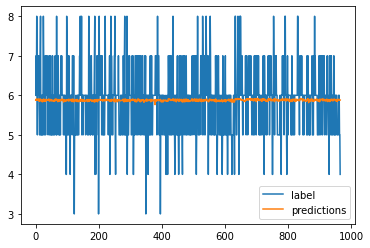

In [135]:
plt.plot(labelWhite,label="label")
plt.plot(predictionWhite,label="predictions")
plt.legend()
# ==> unreadable ==> must see residual plot for more clarity

##### Calculation the RMSE in the test set

In [98]:
from pyspark.sql.functions import sqrt as sqrt_ML
from math import sqrt as sqrt_math

In [115]:
predictionsW=predictionsW.withColumn("residual2", (predictionsW.label-predictionsW.prediction)**2) #RESIDUAL SQUARE (xi_x)²

#############1st method
res=predictionsW.agg({"residual2":"sum","prediction":"count"}).rdd.map(lambda x:(x[0],x[1],sqrt_math(x[1]/x[0]))).collect()
rmse=res[0][2]
print("1st method",rmse)

#############2nd method
res=predictionsW.agg({"residual2":"sum","prediction":"count"})
print("2nd method")
res.withColumn('RMSE',sqrt_ML(res['sum(residual2)']/res['count(prediction)'])).show()

1st method 0.86552497934963
2nd method
+-----------------+-----------------+----------------+
|count(prediction)|   sum(residual2)|            RMSE|
+-----------------+-----------------+----------------+
|              966|723.6629512223194|0.86552497934963|
+-----------------+-----------------+----------------+



##### Plotting histogram on the residual values

In [130]:
# predictionsW.select("residual").rdd.map(lambda x:x[0]).collect()

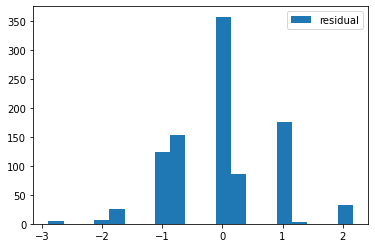

In [118]:
predictionsW=predictionsW.withColumn("residual", (predictionsW.label-predictionsW.prediction)) #RESIDUAL (xi_x)
residualWhite=predictionsW.select("residual").rdd.map(lambda x:x[0]).collect()
plt.hist(residualWhite,bins=20,label="residual")
# plt.plot(predictionWhite,label="predictions")
plt.legend()

<div class="alert alert-block alert-info"> 
    Conclusion The residuals are centred around 0 ==> it's the behavior we want to see
    </div>

### Using the model trained in WhiteWine to RedWine (whole dataset)

In [120]:
predictionsRed=lrModel.transform(redWine)
predictionsRed.show(5)

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|[7.4,0.7,0.0,1.9,...|    5|5.849827333634754|
|[7.8,0.88,0.0,2.6...|    5|5.856754793897473|
|[7.8,0.76,0.04,2....|    5|5.855369301844929|
|[11.2,0.28,0.56,1...|    6| 5.84844184158221|
|[7.4,0.7,0.0,1.9,...|    5|5.849827333634754|
+--------------------+-----+-----------------+
only showing top 5 rows



In [122]:
predictionsRed=predictionsRed.withColumn("residual2", (predictionsRed.label-predictionsRed.prediction)**2)

#############1st method
res=predictionsRed.agg({"residual2":"sum","prediction":"count"}).rdd.map(lambda x:(x[0],x[1],sqrt_math(x[1]/x[0]))).collect()
rmse=res[0][2]
print("1st method",rmse)

#############2nd method
res=predictionsRed.agg({"residual2":"sum","prediction":"count"})
print("2nd method")
res.withColumn('RMSE',sqrt_ML(res['sum(residual2)']/res['count(prediction)'])).show()

1st method 0.8349406288048624
2nd method
+-----------------+------------------+------------------+
|count(prediction)|    sum(residual2)|              RMSE|
+-----------------+------------------+------------------+
|             1599|1114.7042399528655|0.8349406288048624|
+-----------------+------------------+------------------+



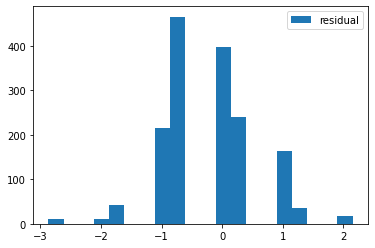

In [125]:
predictionsRed=predictionsRed.withColumn("residual", (predictionsRed.label-predictionsRed.prediction))
residualRed=predictionsRed.select("residual").rdd.map(lambda x:x[0]).collect()
plt.hist(residualRed,bins=20,label="residual")
# plt.plot(predictionWhite,label="predictions")
plt.legend()

<div class="alert alert-block alert-info"> 
    Conclusion: 
    If we look only on the RMSE, the Red RMSE is lower than the White one ==> we might conclude that the model predict well, but if we have a look on the residual plot: 
    The residuals are clearly NOT centred around 0 ==> must train a model only for Red Wine
    </div>

### Training a model only for Red Wine

In [127]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="label")

# Fit the model
lrModelR = lr.fit(trainR)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModelR.coefficients))
print("Intercept: %s" % str(lrModelR.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModelR.summary
print("numIterations: %d" % trainingSummary.totalIterations)
# print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,-0.40668878864381275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 5.87444334538895
numIterations: 11
+-------------------+
|          residuals|
+-------------------+
|-1.6629651752941674|
| 0.2638308427499467|
| 0.2638308427499467|
| 1.3207672731600804|
|  1.465141793128634|
+-------------------+
only showing top 5 rows

RMSE: 0.786418
r2: 0.063017


In [128]:
predictionsR=lrModelR.transform(testR)
predictionsR.show(5,truncate=False)

+----------------------------------------------------+-----+-----------------+
|features                                            |label|prediction       |
+----------------------------------------------------+-----+-----------------+
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6] |6    |5.630430072202662|
|[5.0,1.02,0.04,1.4,0.045,41.0,85.0,0.9938,3.75,0.48]|4    |5.45962078097226 |
|[5.2,0.32,0.25,1.8,0.103,13.0,50.0,0.9957,3.38,0.55]|5    |5.744302933022929|
|[5.7,1.13,0.09,1.5,0.172,7.0,19.0,0.994,3.5,0.48]   |4    |5.414885014221442|
|[6.1,0.38,0.15,1.8,0.072,6.0,19.0,0.9955,3.42,0.57] |5    |5.719901605704301|
+----------------------------------------------------+-----+-----------------+
only showing top 5 rows



In [129]:
predictionsR=predictionsR.withColumn("residual2", (predictionsR.label-predictionsR.prediction)**2) #RESIDUAL SQUARE (xi_x)²

#############1st method
res=predictionsR.agg({"residual2":"sum","prediction":"count"}).rdd.map(lambda x:(x[0],x[1],sqrt_math(x[1]/x[0]))).collect()
rmse=res[0][2]
print("1st method",rmse)

#############2nd method
res=predictionsR.agg({"residual2":"sum","prediction":"count"})
print("2nd method")
res.withColumn('RMSE',sqrt_ML(res['sum(residual2)']/res['count(prediction)'])).show()

1st method 0.7642259582544553
2nd method
+-----------------+------------------+------------------+
|count(prediction)|    sum(residual2)|              RMSE|
+-----------------+------------------+------------------+
|              313|182.80493167949135|0.7642259582544553|
+-----------------+------------------+------------------+



<div class="alert alert-block alert-info"> 
    Conclusion: 
The rmse is lower than the White model used for the red wine dataset
    </div>